In [1]:
# !pip install --upgrade pip
# !pip install pandas
# !cp ./fp_refined.csv /data

In [2]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


import pandas as pd

from tqdm import tnrange, tqdm_notebook


tf.enable_eager_execution()

In [3]:
path_csv = "/data/fp_refined.csv"

df = pd.read_csv(path_csv)
df

,id_after,Path,index,APT_ID,Date,year,norm_year,yyyymm,N_Housings,Max_Floors,...,sido_cluster_code,sido_sgg_name,FP_ID,Area,norm_log_area,area_85,Entrance,Rooms,Baths,N_Units
0,8928_160,/data/fp_img_processed/8928_160.png,1,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,160,134.30,1.313282,False,계단식,4,2,84
1,8928_183,/data/fp_img_processed/8928_183.png,2,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,183,153.80,1.702528,False,계단식,4,2,44
2,8928_201A,/data/fp_img_processed/8928_201A.png,3,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,201A,170.32,1.995448,False,계단식,4,2,42
3,8928_204B,/data/fp_img_processed/8928_204B.png,4,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,...,0,서울시 강남구,204B,168.42,1.963240,False,계단식,4,2,42
4,960_35,/data/fp_img_processed/960_35.png,5,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,35,35.64,-2.495452,False,계단식,2,1,530
5,960_41,/data/fp_img_processed/960_41.png,6,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,41,41.98,-2.025393,False,계단식,2,1,1450
6,960_45,/data/fp_img_processed/960_45.png,7,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,45,45.26,-1.809404,False,계단식,2,1,80
7,960_49F,/data/fp_img_processed/960_49F.png,8,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,49F,49.56,-1.548828,False,계단식,2,1,326
8,960_50S,/data/fp_img_processed/960_50S.png,9,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,50S,50.64,-1.486935,False,계단식,2,1,1470
9,960_53,/data/fp_img_processed/960_53.png,10,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,...,0,서울시 강남구,53,53.63,-1.322233,False,계단식,3,1,65


<IPython.core.display.Javascript object>


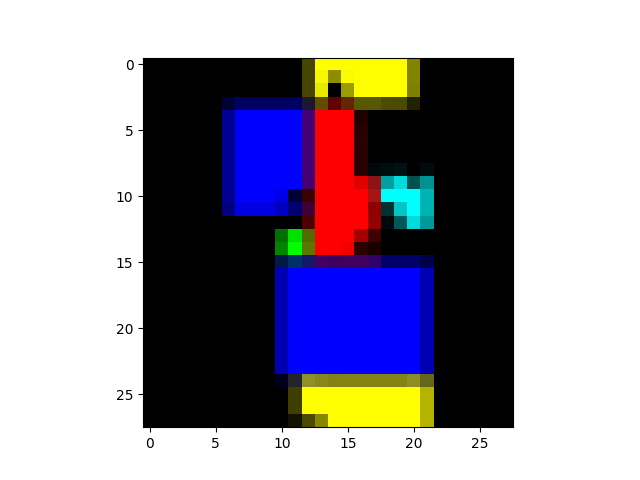

(28, 28, 6)


<IPython.core.display.Javascript object>


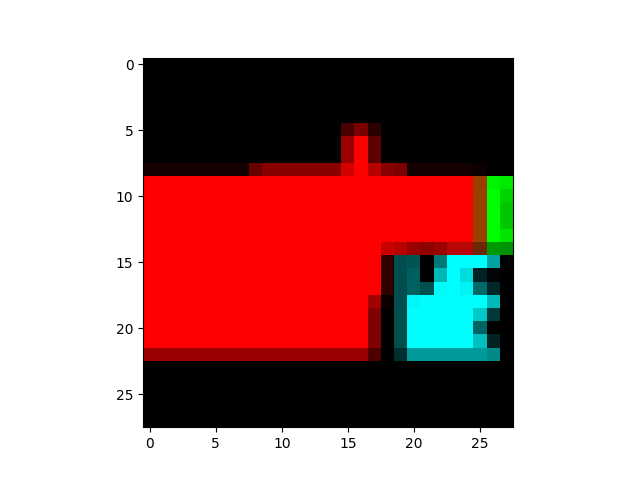

In [4]:
AREA_UNIT = 128
AREA_WALL = 64
AREA_ENTRANCE = 32
AREA_LDK = 16
AREA_BEDROOM = 8
AREA_BALCONY = 4
AREA_BATHROOM = 2

areas = [
    'unit',
    'wall',
    'entrance',
    'LDK',
    'bedroom',
    'balcony'
]

area_mask = [
    AREA_UNIT,
    AREA_WALL,
    AREA_ENTRANCE,
    AREA_LDK,
    AREA_BEDROOM,
    AREA_BALCONY
]


def read_bgr_from_image_unicode(path):
    '''workaround for non-ascii filenames'''
    
    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    
    return bgr

def preprocess_floorplan(path):
    """Returns (28, 28, 6) numpy array of the floorplan image."""
    
    bgr = read_bgr_from_image_unicode(path)
    mono = bgr[:,:,0]
    
    
    _, unit_mask = cv2.threshold(mono & (AREA_UNIT), 1, 255, cv2.THRESH_BINARY)
    _, rooms_mask = cv2.threshold(
        mono & (AREA_ENTRANCE+AREA_LDK+AREA_BEDROOM+AREA_BALCONY+AREA_BATHROOM),
        1, 255, cv2.THRESH_BINARY
    )
    
    unit_rs = np.any(unit_mask, axis=1)
    unit_cs = np.any(unit_mask, axis=0)
    unit_rmin, unit_rmax = np.where(unit_rs)[0][[0, -1]]
    unit_cmin, unit_cmax = np.where(unit_cs)[0][[0, -1]]
    unit_height = unit_rmax - unit_rmin
    unit_width = unit_cmax - unit_cmin
        
    rooms_rs = np.any(rooms_mask, axis=1)
    rooms_cs = np.any(rooms_mask, axis=0)
    rooms_rmin, rooms_rmax = np.where(rooms_rs)[0][[0, -1]]
    rooms_cmin, rooms_cmax = np.where(rooms_cs)[0][[0, -1]]
    rooms_height = rooms_rmax - rooms_rmin
    rooms_width = rooms_cmax - rooms_cmin
    
    size = max(rooms_height, rooms_width)
    
    rmin = (rooms_rmax+rooms_rmin - size)//2
    rmax = (rooms_rmax+rooms_rmin + size)//2
    cmin = (rooms_cmax+rooms_cmin - size)//2
    cmax = (rooms_cmax+rooms_cmin + size)//2
    
    if size >= unit_height:
        rmin = max(0, (unit_rmax+unit_rmin - size)//2)
        rmax = min(mono.shape[0]-1, (unit_rmax+unit_rmin + size)//2)
        rpad = (size - unit_height)//2
    elif rmin < unit_rmin:
        rmin = unit_rmin
        rmax = unit_rmin + size
    elif rmax > unit_rmax:
        rmin = unit_rmax - size
        rmax = unit_rmax 

    if size >= unit_width:
        cmin = max(0, (unit_cmax+unit_cmin - size)//2)
        cmax = min(mono.shape[1]-1, (unit_cmax+unit_cmin + size)//2)
        cpad = (size - unit_width)//2
    elif cmin < unit_cmin:
        cmin = unit_cmin
        cmax = unit_cmin + size
    elif cmax > unit_cmax:
        cmin = unit_cmax - size
        cmax = unit_cmax 

    cropped = mono[rmin:rmax, cmin:cmax]
    rpad = min(0, (size - (rmax-rmin))//2)
    cpad = min(0, (size - (cmax-cmin))//2)
    
    if rpad > 0 or cpad > 0:
        padded = cv2.copyMakeBorder(cropped, rpad, rpad, cpad, cpad, cv2.BORDER_CONSTANT, value=0)
    else:
        padded = cropped
    
#     print(unit_rmin, unit_rmax, unit_cmin, unit_cmax)
#     print(rmin, rmax, cmin, cmax)
#     print(size, rpad, cpad)

    layers = [np.clip(padded&x, 0, 1).astype(float) 
              for x in [AREA_UNIT, AREA_ENTRANCE, AREA_LDK,
                        AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]]
    shrinked_layers = [cv2.resize(x, dsize=(28, 28), interpolation=cv2.INTER_AREA) for x in layers]
#     print(shrinked_layers[3].shape)

    return np.stack(shrinked_layers, axis=2)


def _plot_fp_rgb(six_layers):
    """
    Plot a floorplan with the colors as below:
    LDK: Red, Entrance: Green, Bedroom: Blue
    Balcony: Yellow, Bathroom: Cyan
    """
    
    red = np.amax(six_layers[:,:,[2,4]], axis=2)
    green = np.amax(six_layers[:,:,[1,4,5]], axis=2)
    blue = np.amax(six_layers[:,:,[3,5]], axis=2)
    
    plt.figure()
    plt.imshow(np.stack([red, green, blue], axis=2))
    pass


# def _fp_from_string(bytes):
#     return np.frombuffer(bytes).reshape(28,28,6)

_plot_fp_rgb(preprocess_floorplan('/data/fp_img_processed/2112_49_0.png'))

processed = preprocess_floorplan('/data/fp_img_processed/111792_21A_0.png')
print(processed.shape)
_plot_fp_rgb(processed)

In [6]:
rows = df.loc[:, ['Path', 'id_after', 'norm_year', 'sido_cluster_code', 
                  'norm_log_area', 'area_85', 'Entrance', 'Rooms', 'Baths']].sample(frac=1).values

# rows_test = df_test.loc[:, ['Path', 'id_after', 'norm_year', 'sido_cluster_code', 
#                   'norm_log_area', 'area_85', 'Entrance', 'Rooms', 'Baths']].sample(frac=1).values

# The following functions can be used to convert a value to a type compatible
# with tf.Example.
# https://www.tensorflow.org/tutorials/load_data/tf_records

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _floats_array_feature(value):
    """Returns a float_list from a numpy array of floats / doubles."""
    # https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1)))

In [7]:
# tf.train.Feature(float_list=tf.train.FloatList(value=processed.flatten()))
_floats_array_feature(processed)

float_list {
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0
  value: 0.0

In [8]:
def serialize_example(row):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    
    # ['Path', 'id_after', 'norm_year', 'sido_cluster_code', 
    #  'norm_log_area', 'area_85', 'Entrance', 'Rooms', 'Baths']

    fp = preprocess_floorplan(row[0])
    feature = {
        'floorplan': _floats_array_feature(fp.reshape(-1)),
        'plan_id': _bytes_feature(row[1].encode("utf-8")),
        'norm_year': _float_feature(row[2]),
        'sido': _int64_feature(row[3]), # 0~8
        'norm_area': _float_feature(row[4]),
        'is_area_85': _int64_feature(row[5]), # 0 or 1
        'is_core': _int64_feature(True if row[6]=='계단식' else False), # 0 or 1
        'num_rooms': _int64_feature(row[7]), # 1~7
        'num_baths': _int64_feature(row[8]) # 1~5
    }
    
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

serialize_example(rows[0])[:400]

b'\n\xc2\x94\x01\n\x97\x93\x01\n\tfloorplan\x12\x88\x93\x01\x12\x84\x93\x01\n\x80\x93\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [9]:
example_proto = tf.train.Example.FromString(serialize_example(rows[0]))
example_proto

features {
  feature {
    key: "floorplan"
    value {
      float_list {
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value

In [10]:
path_all_tfrecord = "/data/fp.tfrecord"

options_gzip = tf.python_io.TFRecordOptions(
    compression_type = tf.python_io.TFRecordCompressionType.GZIP
)

errors = []



for (path, rows) in zip([path_all_tfrecord],  
                        [rows]):
    with tf.python_io.TFRecordWriter(path=path, options=options_gzip) as writer:
        for row in tqdm_notebook(rows, desc='Processing plans'):
            try:
                serialized_example = serialize_example(row)
                writer.write(serialized_example)
            except:
                errors.append(row[1])


if errors:
    print(errors)

In [13]:
!ls -al /data/fp*.tfrecord

-rw-r--r-- 1 root root 74689897 Jan 26 08:18 /data/fp.tfrecord


In [14]:
raw_dataset = tf.data.TFRecordDataset(path_all_tfrecord, compression_type="GZIP")
raw_dataset

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [15]:
for raw_record in raw_dataset.take(2): # WARNING: deprecated
    print(repr(raw_record)[:400])

<tf.Tensor: id=20, shape=(), dtype=string, numpy=b'\n\xc2\x94\x01\n\x19\n\x07plan_id\x12\x0e\n\x0c\n\n23112_103F\n\r\n\x04sido\x12\x05\x1a\x03\n\x01\x00\n\x15\n\tnorm_area\x12\x08\x12\x06\n\x04\xfe\x00\x05\xbc\n\x15\n\tnorm_year\x12\x08\x12\x06\n\x04\xecQ8?\n\x10\n\x07is_core\x12\x05\x1a\x03\n\x01\x01\n\x13\n\nis_area_85\x12\x05\x1a\x03\n\x01\x01\n\x12\n\tnum_baths\x12\x05\x1a\x03\n\x01\x02\n\x12\
<tf.Tensor: id=22, shape=(), dtype=string, numpy=b'\n\xbf\x94\x01\n\x12\n\tnum_rooms\x12\x05\x1a\x03\n\x01\x03\n\x97\x93\x01\n\tfloorplan\x12\x88\x93\x01\x12\x84\x93\x01\n\x80\x93\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\


In [16]:
def _parse_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example

parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset 

<DatasetV1Adapter shapes: {floorplan: (28, 28, 6), is_area_85: (), is_core: (), norm_area: (), norm_year: (), num_baths: (), num_rooms: (), plan_id: (), sido: ()}, types: {floorplan: tf.float32, is_area_85: tf.int64, is_core: tf.int64, norm_area: tf.float32, norm_year: tf.float32, num_baths: tf.int64, num_rooms: tf.int64, plan_id: tf.string, sido: tf.int64}>

In [17]:
for parsed_record in parsed_dataset.take(3):
    print(repr(parsed_record))

{'floorplan': <tf.Tensor: id=80, shape=(28, 28, 6), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0